---

This is a code script created AFTER the submission of the [**SIGSIM PADS '25**](https://sigsim.acm.org/conf/pads/2025/), where we presented "Looking for answers: gaze and brain activity as simulation outputs" ([https://doi.org/10.1145/3726301.3731539](https://doi.org/10.1145/3726301.3731539)).

After this submission, we looked deeper into the simulation eye tracking data and reverse-engineered specifically where people would be looking at during their trials. You can find this project on Github [here](https://github.com/SimpleDevs-Research/Street-Sim-V2), with the specific Unity scene `Replay.unity`.

This page specifically looks at the newly-generated eye tracking data from that. Consider this a prequel to the next post-processing notebook, [Main2.ipynb](Main2.ipynb). Make sure to head over there after looking at this.

---

In [5]:
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import datetime

In [8]:
# Manual helper functions from '../helpers.py'

# Get immediate child files
def get_immediate_files(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isfile(os.path.join(a_dir, name))]

In [7]:
# Custom helper function. Process raycast_hit_name into different segments, based on delimiters
def raycast_processing(raw_value):
    if len(raw_value) == 0: return '','','',''
    divided = raw_value.split("-")
    values = divided[0].split('.')
    values.append(divided[1])
    return values

In [22]:
_SAMPLES_DIR = '../data/'
_PARTICIPANTS = ['P1','P2','P3','P4','P5','P6']

# output directory
_OUTPUT_DIR = f'outputs_eyegaze_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/'
try: os.makedirs(_OUTPUT_DIR)
except OSError as e:
    if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..

# Gaze Data - A Preliminary Look

Let's look at the raw eye data itself (with the only filter being that they are constrained to the trial times of each user). We only look at those of trials 1 to 9 for most participants. I'm interested in looking at the mean and distributions of gazes relative to gaze target, as well as a general summary of the angular differences between users' eyes and heads.

In [10]:
# Initialize the arrays of DataFrames to concat later
# We have two arrays: one for the raw eye data, and
# the other for the gazes specifically.
eye_dfs = []
gaze_dfs = []

for p in _PARTICIPANTS:
    # Check if the required file exists
    pdir = os.path.join(_SAMPLES_DIR, p)
    files = get_immediate_files(pdir)
    if not 'eye_targets.csv' in files:
        print(f"`eye_targets.csv` is not present in {p}'s files")
        continue
    
    # Read the trial data for this participant.
    # We simply need this to restrict the eye gazes between a time range.
    trial_df = pd.read_csv(os.path.join(pdir,'trials.csv'))
    start_frame = trial_df['start_frame'].iloc[1]
    end_frame = trial_df['end_frame'].iloc[-1]
    
    # Read the eye target file as a DataFrame.
    df = pd.read_csv(os.path.join(pdir,'eye_targets.csv'))
    
    # Also ensure that the `raycast_hit_name` 
    # is the correct data type with no empty values.
    df['raycast_hit_name'] = df['raycast_hit_name'].convert_dtypes().fillna('')
    
    # Filter `df` by the start and end frames
    df = df[df['frame'].between(start_frame, end_frame)]
    
    # We want to group the rows by `raycast_hit_name`. We call these groups "Gazes".
    # We keep some required rows, such as `unix_ms` and `rel_timestamp` and `frame`.
    grouped = df.groupby('raycast_hit_name', sort=False).first()[['unix_ms','rel_timestamp','frame']]
    gazes = grouped.rename(columns={
        'unix_ms': 'start_unix_ms',
        'rel_timestamp': 'start_rel_timestamp',
        'frame': 'start_frame'
    }).reset_index()

    # Since we labeled each Gaze group as the start timestamps, we need to declare the end timestamp equivalents.
    # We simply use the next Gaze group's start timestamps.
    gazes['end_unix_ms'] = gazes['start_unix_ms'].shift(-1)
    gazes['end_rel_timestamp'] = gazes['start_rel_timestamp'].shift(-1)
    gazes['end_frame'] = gazes['start_frame'].shift(-1)
    
    # For the last Gaze, since there's no latter Gaze, we just get the last known row of the DataFrame
    last_row = df.iloc[-1]
    gazes.iloc[-1, gazes.columns.get_loc('end_unix_ms')] = last_row['unix_ms']
    gazes.iloc[-1, gazes.columns.get_loc('end_rel_timestamp')] = last_row['rel_timestamp']
    gazes.iloc[-1, gazes.columns.get_loc('end_frame')] = last_row['frame']

    # For the Gazes, we calculate their durations
    gazes['duration_frame'] = gazes['end_frame'] - gazes['start_frame']
    gazes['duration_unix_ms'] = gazes['end_unix_ms'] - gazes['start_unix_ms']
    gazes['duration_rel_timestamp'] = gazes['end_rel_timestamp'] - gazes['start_rel_timestamp']

    # Now we split `raycast_hit_name` into different subdivisions, based on some delimiters in the name.
    # We need a helper function `raycast_processing()` for this.
    gazes[['raycast_target_category','raycast_target_type','raycast_target_subtype','raycast_target_name']] = gazes.apply(
        lambda r: raycast_processing(r['raycast_hit_name']), 
        axis='columns', 
        result_type='expand'
    )
    
    # One check: some items have `Vehicel` instead of `Vehicle` 
    # in the 'raycast_target_category' column. Let's fix that
    gazes.loc[gazes['raycast_target_category'] == 'Vehicel', 'raycast_target_category'] = 'Vehicle'    
    
    # As a last step, we make sure to label the two DataFrames 
    # with the participant's ID
    df['participant'] = p
    gazes['particpant'] = p
    
    # Now, add the DataFrames into `eye_dfs` and `gaze_dfs`
    eye_dfs.append(df)
    gaze_dfs.append(gazes)

# Concatenate the DataFrames in both `eye_dfs` and `gaze_dfs` 
# into single DataFrames
eyes_df = pd.concat(eye_dfs, ignore_index=True)
gazes_df = pd.concat(gaze_dfs, ignore_index=True)

display(eyes_df.head(10))
display(gazes_df.head(10))

,unix_ms,rel_timestamp,frame,event,side,screen_pos_x,screen_pos_y,screen_pos_z,target_name,local_direction_x,local_direction_y,local_direction_z,angular_diff,raycast_hit_name,target_distance,participant
0,1742844921609,16.37081,939,Eye Hit,Center,762.0048,676.8984,49.15114,NorthSidewalk,2.887659,-7.912757,49.15114,9.724495,Environment.Sidewalk.North-North.Sidewalk,5.054704,P1
1,1742844921632,16.40114,940,Eye Hit,Center,763.9808,666.0293,49.02143,NorthSidewalk,3.015516,-8.637111,49.02143,10.570970,Environment.Sidewalk.North-North.Sidewalk,4.955316,P1
2,1742844921660,16.42402,941,Eye Hit,Center,769.3951,662.0638,48.95213,NorthSidewalk,3.381955,-8.896409,48.95213,11.002510,Environment.Sidewalk.North-North.Sidewalk,4.849585,P1
3,1742844921687,16.45233,942,Eye Hit,Center,768.5815,667.1960,49.01868,NorthSidewalk,3.330773,-8.556638,49.01868,10.609530,Environment.Sidewalk.North-North.Sidewalk,4.835773,P1
4,1742844921714,16.47840,943,Eye Hit,Center,767.3746,670.4251,49.03080,NorthSidewalk,3.248833,-8.337307,49.03080,10.342450,Environment.Sidewalk.North-North.Sidewalk,4.816074,P1
5,1742844921743,16.50667,944,Eye Hit,Center,767.3808,669.0554,49.01760,NorthSidewalk,3.248382,-8.428968,49.01760,10.441650,Environment.Sidewalk.North-North.Sidewalk,4.805298,P1
6,1742844921771,16.53658,945,Eye Hit,Center,768.5876,665.7220,48.97706,NorthSidewalk,3.328362,-8.650344,48.97706,10.716120,Environment.Sidewalk.North-North.Sidewalk,4.781178,P1
7,1742844921799,16.56381,946,Eye Hit,Center,773.7645,658.8572,48.87540,NorthSidewalk,3.675352,-9.101666,48.87540,11.355760,Environment.Sidewalk.North-North.Sidewalk,4.710323,P1
8,1742844921827,16.59200,947,Eye Hit,Center,773.6099,655.1757,48.83628,NorthSidewalk,3.661852,-9.345846,48.83628,11.614620,Environment.Sidewalk.North-North.Sidewalk,4.704583,P1
9,1742844921855,16.61921,948,Eye Hit,Center,773.9236,649.2659,48.76516,NorthSidewalk,3.677910,-9.735318,48.76516,12.046680,Environment.Sidewalk.North-North.Sidewalk,4.721047,P1


,raycast_hit_name,start_unix_ms,start_rel_timestamp,start_frame,end_unix_ms,end_rel_timestamp,end_frame,duration_frame,duration_unix_ms,duration_rel_timestamp,raycast_target_category,raycast_target_type,raycast_target_subtype,raycast_target_name,particpant
0,Environment.Sidewalk.North-North.Sidewalk,1742844921609,16.37081,939,1.742845e+12,16.70479,951.0,12.0,332.0,0.33398,Environment,Sidewalk,North,North.Sidewalk,P1
1,Environment.Buildings.North-North.Buildings,1742844921941,16.70479,951,1.742845e+12,17.76897,992.0,41.0,1049.0,1.06418,Environment,Buildings,North,North.Buildings,P1
2,Environment.Tree.NW10m-NW.Tree.10,1742844922990,17.76897,992,1.742845e+12,17.79568,994.0,2.0,30.0,0.02671,Environment,Tree,NW10m,NW.Tree.10,P1
3,Environment.Road.West-Road.West,1742844923020,17.79568,994,1.742845e+12,17.96957,1006.0,12.0,173.0,0.17389,Environment,Road,West,Road.West,P1
4,Environment.Sidewalk.South-South.Sidewalk,1742844923193,17.96957,1006,1.742845e+12,18.08619,1014.0,8.0,118.0,0.11662,Environment,Sidewalk,South,South.Sidewalk,P1
5,Environment.Buildings.South-South.Buildings,1742844923311,18.08619,1014,1.742845e+12,18.17554,1020.0,6.0,89.0,0.08935,Environment,Buildings,South,South.Buildings,P1
6,Environment.Tree.SW10m-SW.Tree.10,1742844923400,18.17554,1020,1.742845e+12,18.84751,1064.0,44.0,674.0,0.67197,Environment,Tree,SW10m,SW.Tree.10,P1
7,Vehicle.MicroBus.Body-MicroBus1.Body,1742844924074,18.84751,1064,1.742845e+12,18.86446,1065.0,1.0,25.0,0.01695,Vehicle,MicroBus,Body,MicroBus1.Body,P1
8,Vehicle.MicroBus.Door-MicroBus1.Door.FR,1742844924099,18.86446,1065,1.742845e+12,18.90676,1067.0,2.0,33.0,0.04230,Vehicle,MicroBus,Door,MicroBus1.Door.FR,P1
9,Vehicle.MicroBus.Driver-MicroBus1.Driver,1742844924132,18.90676,1067,1.742845e+12,19.00778,1073.0,6.0,105.0,0.10102,Vehicle,MicroBus,Driver,MicroBus1.Driver,P1


## Figure Visualizations

### Gazes By Category

Text(0.5, 0, 'Gaze Target Categories')

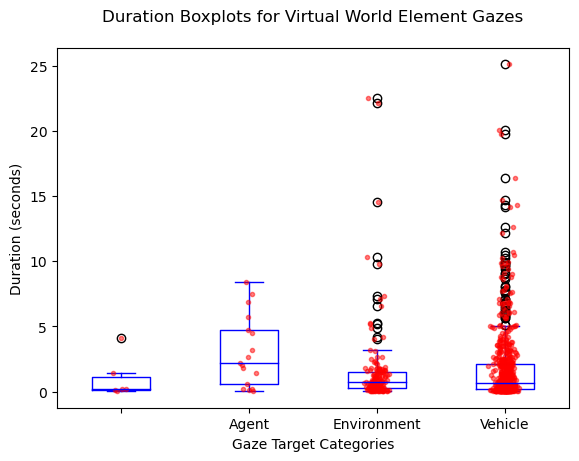

In [12]:
# Get unique values in `raycast_target_category`
target_categories = sorted(gazes_df['raycast_target_category'].unique())

# Draw boxplot
bp = gazes_df.boxplot(column='duration_rel_timestamp', by='raycast_target_category', grid=False, color='blue')

# Add data on top
for i in range(0,len(target_categories)):
    c = target_categories[i]
    y = gazes_df['duration_rel_timestamp'][gazes_df['raycast_target_category'] == c].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.04, size=len(y))
    # Plot via `pyplot`
    pylab.plot(x, y, 'r.', alpha=0.5)

pylab.suptitle('Duration Boxplots for Virtual World Element Gazes')
pylab.title(None)
pylab.ylabel('Duration (seconds)')
pylab.xlabel('Gaze Target Categories')

It appears that most gazes are on either the environment or on vehicles, with a majority on the vehicles. This makes sense - the main road-crossing task encourages people to look at vehicles to prevent collisions. We also barely see any glances on the other virtual pedestrians, and some gazes don't actually land on anything (maybe they're looking upward at the sky). 

Based purely on the boxplots for the Environment and Vehicles, we see that the means appear to gravitate to around 1-2 seconds. There's definitely a ton of outliers, but the boxplots having their means and SDs so small (less than 5 seconds) means that we can expect people to generally only look at these gaze targets for around 1-2 seconds.

There can be several reasons for this. The first is that some of these glances can be purely transitional - i.e. they're in the transition from one target to the other. The other likely scenario is that people really only need to look at targets at very quick glances in order to ascertain their situational contexts. This would speak to people's natural ability to judge distances, observe when situations are dangerous or not, etc. It's hard to look at these in isolation to derive what's happening here.

---

We COULD attempt to isolate the glances based on some time threshold, but it doesn't consider the situation where the gazes are really informative but are short (the 2nd scenario mentioned above). We need to go further to provide the necessary contexts:

* Were they waiting at the sidewalk or in the middle of crossing the road?
* Were they actually fixating or just lazy-ing around? We would need to look at EEG data for this.

### Environment-Specific Gazes

Text(0.5, 0, 'Environment-Specific Gaze Target')

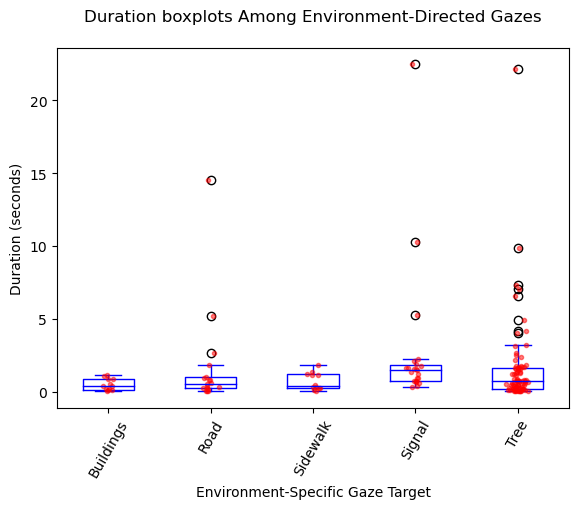

In [13]:
# Only look at the environment
environment = gazes_df[gazes_df['raycast_target_category']=='Environment']
target_subtypes = sorted(environment['raycast_target_type'].unique())

# Draw boxplot
bp = environment.boxplot(
    column='duration_rel_timestamp', 
    by='raycast_target_type', 
    grid=False, color='blue', rot=60)

# Add data on top
for i in range(0,len(target_subtypes)):
    c = target_subtypes[i]
    y = environment['duration_rel_timestamp'][environment['raycast_target_type'] == c].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.04, size=len(y))
    pylab.plot(x, y, 'r.', alpha=0.5)

pylab.suptitle('Duration boxplots Among Environment-Directed Gazes')
pylab.title(None)
pylab.ylabel('Duration (seconds)')
pylab.xlabel('Environment-Specific Gaze Target')

The most interesting thing, legitimiately, is the fact that the TREES got the most attention, if we're looking purely at just raw gaze data. It's kind of hilarious in hindsight. However, I think what this DOES speak to is that the trees act as a kind of obstacle. When a user looks left or right, maybe their gaze gets occluded by the trees that are in the distance.

There is a phenomenon (and a potential study topic) where we can maybe use eye tracking to observe the amount of occlusion a user experiences while on the road. One of our earlier ideas was to explore different occlusion barriers as a factor for road safety in simulation, using common roadside occludors such as food trucks or plants to visually block incoming vehicles. This may lend some credence to this kind of work in the future.

### Vehicle-Specific Gaze Types

Text(0.5, 0, 'Vehicle-Specific Gaze Target')

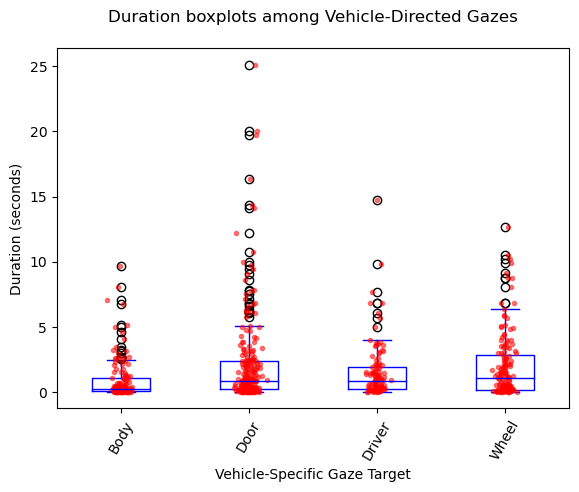

In [14]:
# Only look at vehicles.
vehicles = gazes_df[gazes_df['raycast_target_category']=='Vehicle']
target_subtypes = sorted(vehicles['raycast_target_subtype'].unique())

# Draw boxplot
bp = vehicles.boxplot(
    column='duration_rel_timestamp', 
    by='raycast_target_subtype', 
    grid=False, color='blue', rot=60)

# Add data on top
for i in range(0,len(target_subtypes)):
    c = target_subtypes[i]
    y = vehicles['duration_rel_timestamp'][vehicles['raycast_target_subtype'] == c].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.04, size=len(y))
    pylab.plot(x, y, 'r.', alpha=0.5)

pylab.suptitle('Duration boxplots among Vehicle-Directed Gazes')
pylab.title(None)
pylab.ylabel('Duration (seconds)')
pylab.xlabel('Vehicle-Specific Gaze Target')

This one is a bit more interesting. When we isolate to just the vehicle gazes, we see that people tend to equally look at the doors, driver, and wheels pretty consistently. People don't really look at other elements of the vehicles, which is indicative of the Body label. The Doors appear to get the most attention, though this can just be because glances just naturally move along the sides of vehicles. The numerous amount of outliers would indicate that a lot of these may just be casual in nature. The same goes for the wheels - the unnatural amount of outliers just tells me that many of these may just be outliers. The glances at the drivers is pretty interesting in of itself. However, just like the previous graph, it's hard to tell just from these in isolation. 

### Eye Angular Differences

<Figure size 1000x1000 with 0 Axes>

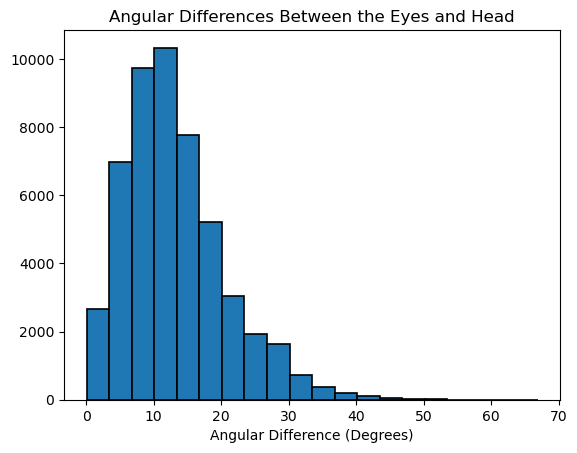

In [15]:
# Plottin angular differences. We need to go back to our original eye data
plt.figure(figsize=(10,10))
eyes_df.hist(column='angular_diff', bins=20, edgecolor='black', linewidth=1.2, grid=False)
plt.title('Angular Differences Between the Eyes and Head')
plt.xlabel('Angular Difference (Degrees)')
plt.show()

You can consider these another side interest in the data. Basically, we understand that people will not divert their eye gaze away from their head between 10-30 degrees; anything beyond that, and the head and eyes move together. There appears to be the general consensus that people will tend to move their head first, and then their eyes will follow. I would argue that context is important - if you already know where you're gonna look, then you're naturally going to turn your head first. However, I'm interested in situations of surprise, where something unexpected happens and you try to glance at it. This could apply to items that were originally in one's viewpoint that are moving into the periphery, for example.

The data here seems to indicate a correlation with what's known about eye physiology - that the angular differences (in degrees) between the forward direction of the head and the eyes means around 10-20 degrees. Very rarely do we see glances that are 30-40 degrees in difference. This must naturally be contrasted against the reality that the Meta Quest Pro, which we collected the data with, has a narrower FOV than real-world vision. However, within that 100-ish FOV (as compared to the 210-degree FOV of real-world vision), the pattern still holds: people will move their eyes up to approximately 20 degrees away from their forward vision, up to which then the head will also move.

# Next Step: Adding Context

Let's step up our game here. We concluded above that without additional situational contexts to the glances here, we won't be able to go further with the gaze analysis. I'm specifically interested in labeling these glances based on whether a person is waiting to cross vs. crossing as a first step. The next step would be the EEG signals that correspond to these glances.

## Understanding Trial Phases

Trials can be easily divided into two segments: a **waiting** phase, and a **crossing** phase. Based on our analyses, there will ALWAYS be at least one **waiting** and one **crossing** phases for each trial. So let's attempt to derive that data.

To do this, we need to get the `positions` data from each participant. However, while we have `positions.csv` from the first batch of analysis, we also have a second `positions_mod.csv` calculated at the same time as our new eye tracking data above. However, I think we can safely look at the original `positions.csv` data. This is because we're only interested in one GameObject among all the positions of all agents in the simulation: `CenterEyeAnchor`.

In [16]:
# Note that, in the simulation, the road area is defined by a Z-position range.
_ROAD_RANGE = [2.25, 7.75]

# we will create new dataframe list  for this second round of processing
eye2_dfs = []
gaze2_dfs = []

# Unlike the eye data above, we loop through indices.
# This is because later, we'll be revising the dataframes in `eye_dfs`
# and `gaze_dfs` by index. So iterate by index we go...
for i in range(len(_PARTICIPANTS)):
    # Get our participant directory, check if we have a positions file
    p = _PARTICIPANTS[i]
    pdir = os.path.join(_SAMPLES_DIR, p)
    files = get_immediate_files(pdir)
    if not 'positions.csv' in files:
        print(f"`positions.csv` is not present in {p}'s files")
        continue
        
    # Read the trial data for this participant.
    # We simply need this to restrict the eye gazes between a time range.
    trial_df = pd.read_csv(os.path.join(pdir,'trials.csv'))
    trial_df = trial_df.iloc[1:]
    start_frame = trial_df['start_frame'].iloc[0]
    end_frame = trial_df['end_frame'].iloc[-1]

    # Read the `positions.csv` file.
    # And filter by start and end frames
    # And get only the center eye anchor
    pos_df = pd.read_csv(os.path.join(pdir, 'positions.csv'))
    pos_df = pos_df[pos_df['frame'].between(start_frame, end_frame)]
    pos_df = pos_df[pos_df['obj_name'] == 'CenterEyeAnchor']
    pos_df = pos_df.reset_index(drop=True)
    
    # One thing we want to do first, copied over from `main.ipynb`,
    # is to calculate the speed of the user per sample.
    pos_df['time_diff'] = pos_df['unix_ms'].diff() / 1000 # unix ms to sec
    pos_df['displacement'] = np.sqrt((pos_df['pos_x'].diff()**2) + (pos_df['pos_z'].diff()**2))
    pos_df['speed'] = pos_df['displacement'] / pos_df['time_diff']
    
    # Make sure we don't have NaN values in the first sample row
    pos_df.iloc[0, pos_df.columns.get_loc('time_diff')] = 0
    pos_df.iloc[0, pos_df.columns.get_loc('displacement')] = 0
    pos_df.iloc[0, pos_df.columns.get_loc('speed')] = 0
    
    # Calculate crossing moments
    moving_df = pos_df[pos_df['pos_z'].between(_ROAD_RANGE[0], _ROAD_RANGE[1])]
    moving_df['next_frame'] = moving_df['frame'].shift(-1)
    moving_df['frame_diff'] = moving_df['next_frame'] - moving_df['frame']
    moving_df['group'] = (moving_df['next_frame'] != moving_df['frame'] + 1).cumsum()
    moving_df = moving_df[moving_df['frame_diff']==1]
    
    # Crossings defined by combinin g disparate movement segments
    crossing_df = moving_df.groupby('group').agg(
        start_unix_ms=('unix_ms', 'first'),
        start_frame=('frame','first'),
        start_rel_timestamp=('rel_timestamp','first'),
        end_unix_ms=('unix_ms', 'last'),
        end_frame=('frame','last'),
        end_rel_timestamp=('rel_timestamp','last'),
        group=('group','first')
    )
    crossing_df = crossing_df.reset_index(drop=True)
    crossing_df = crossing_df.drop(columns=['group'])
    
    # Label each position based on whether the user is crossing or not.
    crossing_intervals = pd.IntervalIndex.from_arrays(crossing_df['start_frame'], crossing_df['end_frame'], closed='both')
    pos_df['crossing'] = pos_df['frame'].apply(lambda frame: any(frame in interval for interval in crossing_intervals))
    
    # Let's mod our eye data, then re-generate our gaze data.
    # We'll add two new columns: one for when the participant is crossing or not.
    # The other is whe movement speed of the user in that frame.
    # That second column requires a `speed_df` that only contains the frame and 
    # the movement speed of the user.
    eye_df = eye_dfs[i]
    eye_df['crossing'] = eye_df['frame'].apply(lambda frame: any(frame in interval for interval in crossing_intervals))
    speed_df = pos_df[['frame','speed']]
    eye2_df = pd.merge(eye_df, speed_df, on='frame', how='left')
    eye2_df = eye2_df.rename(columns={'speed':'movement_speed'})
    
    # With that, let's recreate our gaze dataframe.
    # The only difference in the grouping is that we group by both `raycast_hit_name` and `crossing`
    grouped = eye2_df.groupby(['raycast_hit_name','crossing'], sort=False).first()[['unix_ms','rel_timestamp','frame']]
    gazes = grouped.rename(columns={
        'unix_ms': 'start_unix_ms',
        'rel_timestamp': 'start_rel_timestamp',
        'frame': 'start_frame'
    }).reset_index()

    # Since we labeled each Gaze group as the start timestamps, we need to declare the end timestamp equivalents.
    # We simply use the next Gaze group's start timestamps.
    gazes['end_unix_ms'] = gazes['start_unix_ms'].shift(-1)
    gazes['end_rel_timestamp'] = gazes['start_rel_timestamp'].shift(-1)
    gazes['end_frame'] = gazes['start_frame'].shift(-1)
    
    # For the last Gaze, since there's no latter Gaze, we just get the last known row of the DataFrame
    last_row = eye2_df.iloc[-1]
    gazes.iloc[-1, gazes.columns.get_loc('end_unix_ms')] = last_row['unix_ms']
    gazes.iloc[-1, gazes.columns.get_loc('end_rel_timestamp')] = last_row['rel_timestamp']
    gazes.iloc[-1, gazes.columns.get_loc('end_frame')] = last_row['frame']

    # For the Gazes, we calculate their durations
    gazes['duration_frame'] = gazes['end_frame'] - gazes['start_frame']
    gazes['duration_unix_ms'] = gazes['end_unix_ms'] - gazes['start_unix_ms']
    gazes['duration_rel_timestamp'] = gazes['end_rel_timestamp'] - gazes['start_rel_timestamp']

    # The only difference here now is that we ensure that we only have gazes that are guaranteed to have a raycast target
    gazes = gazes[gazes['raycast_hit_name'].map(len) > 0]
    
    # Now we split `raycast_hit_name` into different subdivisions, based on some delimiters in the name.
    # We need a helper function `raycast_processing()` for this.
    gazes[['raycast_target_category','raycast_target_type','raycast_target_subtype','raycast_target_name']] = gazes.apply(
        lambda r: raycast_processing(r['raycast_hit_name']), 
        axis='columns', 
        result_type='expand'
    )
    
    # One check: some items have `Vehicel` instead of `Vehicle` 
    # in the 'raycast_target_category' column. Let's fix that
    gazes.loc[gazes['raycast_target_category'] == 'Vehicel', 'raycast_target_category'] = 'Vehicle'    
    
    # As a last step, we make sure to label the new gazes DataFrame 
    # with the participant's ID. The eye2 dataframe already has that info.
    gazes['particpant'] = p
    
    # let's save our new eye and gaze data into the output folders
    p_output_dir = os.path.join(_OUTPUT_DIR, p)
    try: os.makedirs(p_output_dir)
    except OSError as e:
        if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..
    
    eye2_df.to_csv(os.path.join(p_output_dir, 'eye_output.csv'))
    gazes.to_csv(os.path.join(p_output_dir, 'gaze_output.csv'))
    
    # Add our new dataframes to our new lists
    eye2_dfs.append(eye2_df)
    gaze2_dfs.append(gazes)

# And now, like before, we concat both lists of dataframes
eyes2_df = pd.concat(eye2_dfs, ignore_index=True)
gazes2_df = pd.concat(gaze2_dfs, ignore_index=True)
display(eyes2_df.head(10))
display(gazes2_df.head(10))

,unix_ms,rel_timestamp,frame,event,side,screen_pos_x,screen_pos_y,screen_pos_z,target_name,local_direction_x,local_direction_y,local_direction_z,angular_diff,raycast_hit_name,target_distance,participant,crossing,movement_speed
0,1742844921609,16.37081,939,Eye Hit,Center,762.0048,676.8984,49.15114,NorthSidewalk,2.887659,-7.912757,49.15114,9.724495,Environment.Sidewalk.North-North.Sidewalk,5.054704,P1,True,0.000000
1,1742844921632,16.40114,940,Eye Hit,Center,763.9808,666.0293,49.02143,NorthSidewalk,3.015516,-8.637111,49.02143,10.570970,Environment.Sidewalk.North-North.Sidewalk,4.955316,P1,True,1.326084
2,1742844921660,16.42402,941,Eye Hit,Center,769.3951,662.0638,48.95213,NorthSidewalk,3.381955,-8.896409,48.95213,11.002510,Environment.Sidewalk.North-North.Sidewalk,4.849585,P1,True,1.043244
3,1742844921687,16.45233,942,Eye Hit,Center,768.5815,667.1960,49.01868,NorthSidewalk,3.330773,-8.556638,49.01868,10.609530,Environment.Sidewalk.North-North.Sidewalk,4.835773,P1,True,1.194430
4,1742844921714,16.47840,943,Eye Hit,Center,767.3746,670.4251,49.03080,NorthSidewalk,3.248833,-8.337307,49.03080,10.342450,Environment.Sidewalk.North-North.Sidewalk,4.816074,P1,True,1.106294
5,1742844921743,16.50667,944,Eye Hit,Center,767.3808,669.0554,49.01760,NorthSidewalk,3.248382,-8.428968,49.01760,10.441650,Environment.Sidewalk.North-North.Sidewalk,4.805298,P1,True,1.138301
6,1742844921771,16.53658,945,Eye Hit,Center,768.5876,665.7220,48.97706,NorthSidewalk,3.328362,-8.650344,48.97706,10.716120,Environment.Sidewalk.North-North.Sidewalk,4.781178,P1,False,1.127397
7,1742844921799,16.56381,946,Eye Hit,Center,773.7645,658.8572,48.87540,NorthSidewalk,3.675352,-9.101666,48.87540,11.355760,Environment.Sidewalk.North-North.Sidewalk,4.710323,P1,False,1.227641
8,1742844921827,16.59200,947,Eye Hit,Center,773.6099,655.1757,48.83628,NorthSidewalk,3.661852,-9.345846,48.83628,11.614620,Environment.Sidewalk.North-North.Sidewalk,4.704583,P1,False,1.152394
9,1742844921855,16.61921,948,Eye Hit,Center,773.9236,649.2659,48.76516,NorthSidewalk,3.677910,-9.735318,48.76516,12.046680,Environment.Sidewalk.North-North.Sidewalk,4.721047,P1,False,1.251686


,raycast_hit_name,crossing,start_unix_ms,start_rel_timestamp,start_frame,end_unix_ms,end_rel_timestamp,end_frame,duration_frame,duration_unix_ms,duration_rel_timestamp,raycast_target_category,raycast_target_type,raycast_target_subtype,raycast_target_name,particpant
0,Environment.Sidewalk.North-North.Sidewalk,True,1742844921609,16.37081,939,1.742845e+12,16.53658,945.0,6.0,162.0,0.16577,Environment,Sidewalk,North,North.Sidewalk,P1
1,Environment.Sidewalk.North-North.Sidewalk,False,1742844921771,16.53658,945,1.742845e+12,16.70479,951.0,6.0,170.0,0.16821,Environment,Sidewalk,North,North.Sidewalk,P1
2,Environment.Buildings.North-North.Buildings,False,1742844921941,16.70479,951,1.742845e+12,17.76897,992.0,41.0,1049.0,1.06418,Environment,Buildings,North,North.Buildings,P1
3,Environment.Tree.NW10m-NW.Tree.10,False,1742844922990,17.76897,992,1.742845e+12,17.79568,994.0,2.0,30.0,0.02671,Environment,Tree,NW10m,NW.Tree.10,P1
4,Environment.Road.West-Road.West,False,1742844923020,17.79568,994,1.742845e+12,17.96957,1006.0,12.0,173.0,0.17389,Environment,Road,West,Road.West,P1
5,Environment.Sidewalk.South-South.Sidewalk,False,1742844923193,17.96957,1006,1.742845e+12,18.08619,1014.0,8.0,118.0,0.11662,Environment,Sidewalk,South,South.Sidewalk,P1
6,Environment.Buildings.South-South.Buildings,False,1742844923311,18.08619,1014,1.742845e+12,18.17554,1020.0,6.0,89.0,0.08935,Environment,Buildings,South,South.Buildings,P1
7,Environment.Tree.SW10m-SW.Tree.10,False,1742844923400,18.17554,1020,1.742845e+12,18.84751,1064.0,44.0,674.0,0.67197,Environment,Tree,SW10m,SW.Tree.10,P1
8,Vehicle.MicroBus.Body-MicroBus1.Body,False,1742844924074,18.84751,1064,1.742845e+12,18.86446,1065.0,1.0,25.0,0.01695,Vehicle,MicroBus,Body,MicroBus1.Body,P1
9,Vehicle.MicroBus.Door-MicroBus1.Door.FR,False,1742844924099,18.86446,1065,1.742845e+12,18.90676,1067.0,2.0,33.0,0.04230,Vehicle,MicroBus,Door,MicroBus1.Door.FR,P1


## Figure Visualizations Pt. 2

This time, we'll be using Seaborn for most of our plotting.

### Gazes By Category

/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


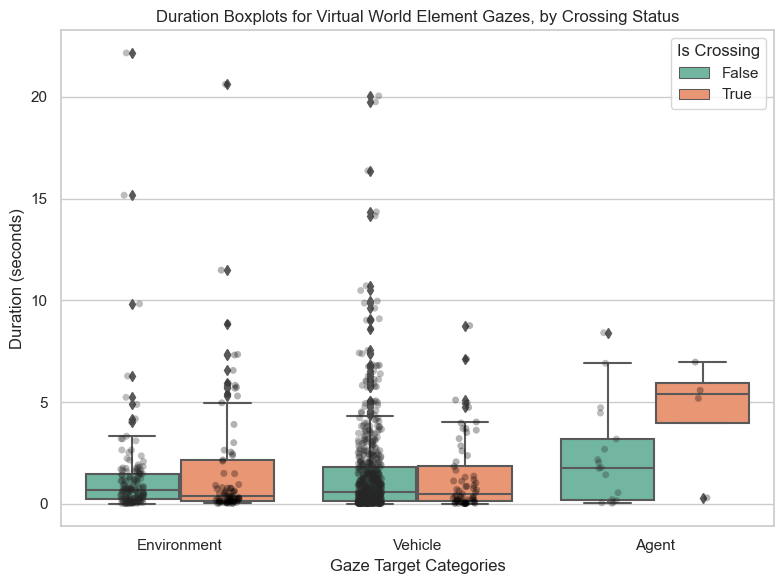

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Define our boxplots
sns.boxplot(
    data=gazes2_df, 
    x='raycast_target_category', 
    y='duration_rel_timestamp', 
    hue='crossing', 
    palette='Set2', 
    dodge=True
)

# Stripplot for raw data
sns.stripplot(
    data=gazes2_df, 
    x='raycast_target_category', 
    y='duration_rel_timestamp', 
    hue='crossing',
    dodge=True,
    jitter=0.1,
    color='black',
    alpha=0.3, 
    marker='o'
)

# Adjust legend (Seaborn duplicates it)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Is Crossing')

plt.title('Duration Boxplots for Virtual World Element Gazes, by Crossing Status')
plt.ylabel('Duration (seconds)')
plt.xlabel('Gaze Target Categories')
plt.tight_layout()

plt.savefig(os.path.join(_OUTPUT_DIR, 'gaze_by_category.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DIR, 'gaze_by_category.pdf'), format='pdf', bbox_inches='tight')
plt.show()

In the first version without the crossing distinction, we noted that most gaze points appear to focus on the environment and vehicles. It appears that the same holds true here.

Categorizing the data between moments of crossing and not crossing reveals that, when users are NOT crossing (i.e. they are waiting to cross), their gazes towards the vehicles is much more pronounced. People will still look at vehicles while crossing too, but not at such a frequency.

Environment glances appear to be similarly distributed between waiting and crossing.

Similarly, the means appear to restrict the length of gaze to around 1-2 seconds.

I think the findings don't really reveal a whole ton of novelty compared to the first graph, but it's good to know that there's this much clarity, at least.

### Environment-Specific Gazes

/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


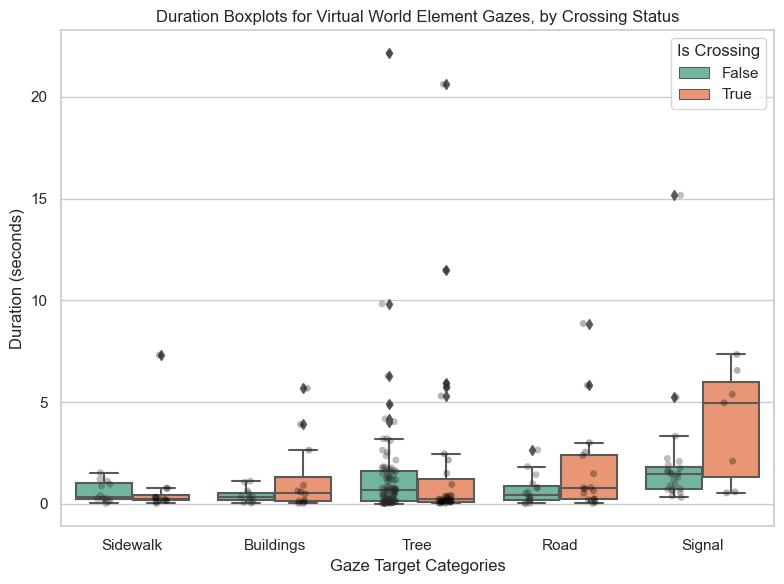

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

env_gazes_df = gazes2_df[gazes2_df['raycast_target_category']=='Environment']

# Define our boxplots
sns.boxplot(
    data=env_gazes_df, x='raycast_target_type', y='duration_rel_timestamp', 
    hue='crossing', palette='Set2', dodge=True
)

# Stripplot for raw data
sns.stripplot(
    data=env_gazes_df, x='raycast_target_type', y='duration_rel_timestamp', 
    hue='crossing', dodge=True, jitter=0.1, color='black', alpha=0.3, marker='o'
)

# Adjust legend (Seaborn duplicates it)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Is Crossing')

plt.title('Duration Boxplots for Virtual World Element Gazes, by Crossing Status')
plt.ylabel('Duration (seconds)')
plt.xlabel('Gaze Target Categories')
plt.tight_layout()

plt.savefig(os.path.join(_OUTPUT_DIR, 'gaze_by_env.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DIR, 'gaze_by_env.pdf'), format='pdf', bbox_inches='tight')
plt.show()

This graph gives us a bit of a better idea of the gaze distributions with relation to environmental factors during either waiting or crossing. I pointed out last time that a lot of gaze fixations appear to be guided towards the trees, more than anything. I think what this explicitly clarifies is that the tree gazing appears to be focused during the waiting phase. This would correlate nicely with the narrative that these things were naturally obstructive to people 

It would also appear that with regard to traffic signals specifically, people looked more often at the signals while waiting. This, of course, makes sense - why would you look at the traffic signals if you are in the middle of crossing already?

I am somewhat surprised by the amount of time people spend looking at the road though. Though I imagine that these are just passing glances rather than anything meaningful.

### Vehicle-Specific Gaze Types

/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


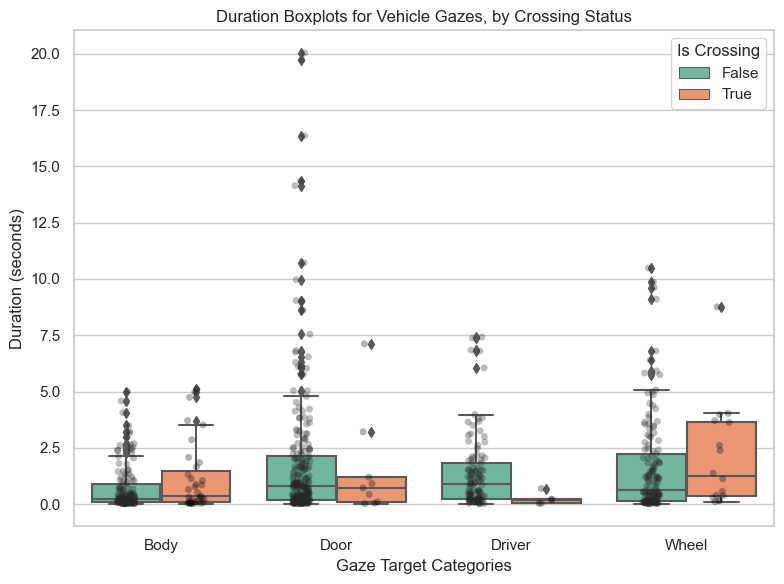

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

veh_gazes_df = gazes2_df[gazes2_df['raycast_target_category']=='Vehicle']

# Define our boxplots
sns.boxplot(
    data=veh_gazes_df, x='raycast_target_subtype', y='duration_rel_timestamp', 
    hue='crossing', palette='Set2', dodge=True
)

# Stripplot for raw data
sns.stripplot(
    data=veh_gazes_df, x='raycast_target_subtype', y='duration_rel_timestamp', 
    hue='crossing', dodge=True, jitter=0.1, color='black', alpha=0.3, marker='o'
)

# Adjust legend (Seaborn duplicates it)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Is Crossing')

plt.title('Duration Boxplots for Vehicle Gazes, by Crossing Status')
plt.ylabel('Duration (seconds)')
plt.xlabel('Gaze Target Categories')
plt.tight_layout()

plt.savefig(os.path.join(_OUTPUT_DIR, 'gaze_by_vehicles.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(_OUTPUT_DIR, 'gaze_by_vehicles.pdf'), format='pdf', bbox_inches='tight')
plt.show()

This one is much more clear on the nature of gaze behaviors towards vehicles. Naturally, we see the general trend that people will look mostly at vehicles while they're waiting. Gazes at the vehicles during crossing are somewhat fewer in number.

The most interesting, and I think compelling thing to consider, is the amount of gaze fixations made to the drivers specifically. This indicates that there IS some non-verbal communication going on with the drivers and pedestrians. At the very least, people felt compelled to look at the drivers. This is pretty indicative of the quality and focus people pay attention to while waiting.

### Eye Angular Differences

/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ryankim/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1

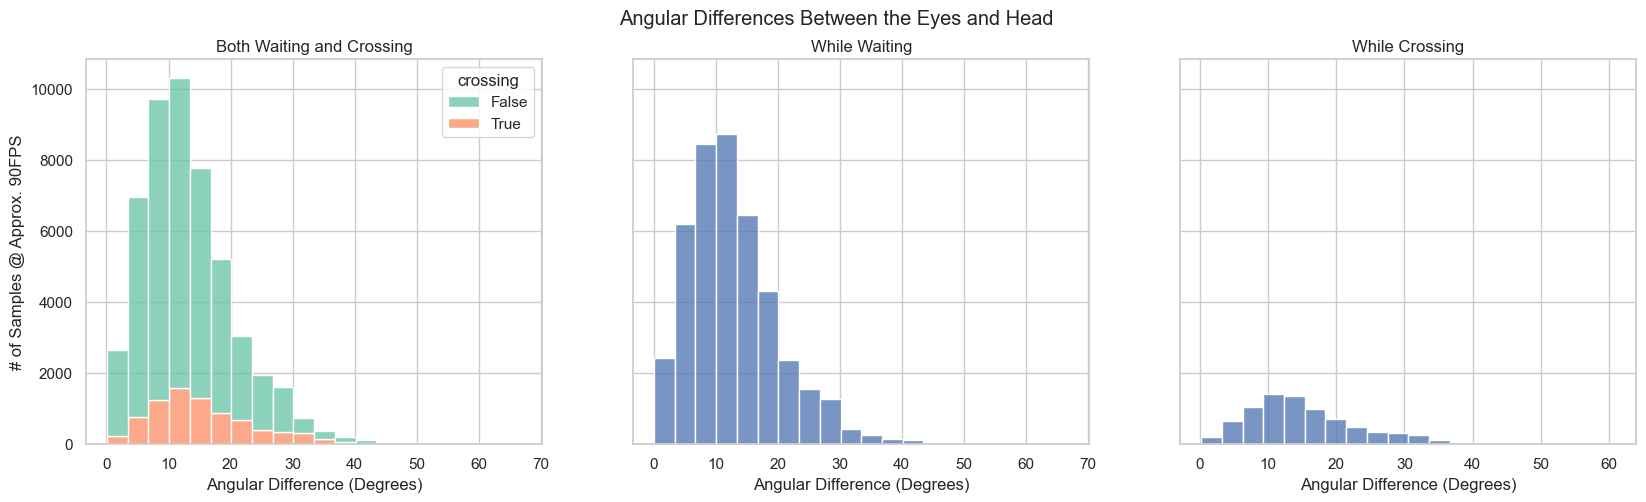

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharey=True)

# Plot the histogram in the first 
sns.histplot(
    data=eyes2_df, 
    x='angular_diff', 
    hue='crossing', 
    palette='Set2',
    multiple='stack', 
    ax=axes[0], 
    bins=20)
axes[0].set_title('Both Waiting and Crossing')
axes[0].set_xlabel('Angular Difference (Degrees)')
axes[0].set_ylabel('# of Samples @ Approx. 90FPS')

# Plot the histogram in the second, which only contains waiting data
sns.histplot(
    data=eyes2_df[~eyes2_df['crossing']], 
    x='angular_diff', 
    multiple='stack', 
    ax=axes[1], 
    bins=20)
axes[1].set_title('While Waiting')
axes[1].set_xlabel('Angular Difference (Degrees)')
axes[1].set_ylabel('# of Samples @ Approx. 90FPS')
axes[1].legend().remove()

# Plot the histogram in the second, which only contains crossing data
sns.histplot(
    data=eyes2_df[eyes2_df['crossing']], 
    x='angular_diff', 
    multiple='stack', 
    ax=axes[2], 
    bins=20)
axes[2].set_title('While Crossing')
axes[2].set_xlabel('Angular Difference (Degrees)')
axes[2].set_ylabel('# of Samples @ Approx. 90FPS')
axes[2].legend().remove()

fig.suptitle('Angular Differences Between the Eyes and Head')

#plt.xlabel('Angular Difference (Degrees)')
plt.show()

I don't think it's really a surprise to see that the eye-head differences maintain the same distribution curve even when the person is on the crosswalk and is probably walking. This shows how consistent this behavior is even in the VR condition!

The last thing I want to check is whether there's something to be had by comparing angular difference and the user's movement speed...

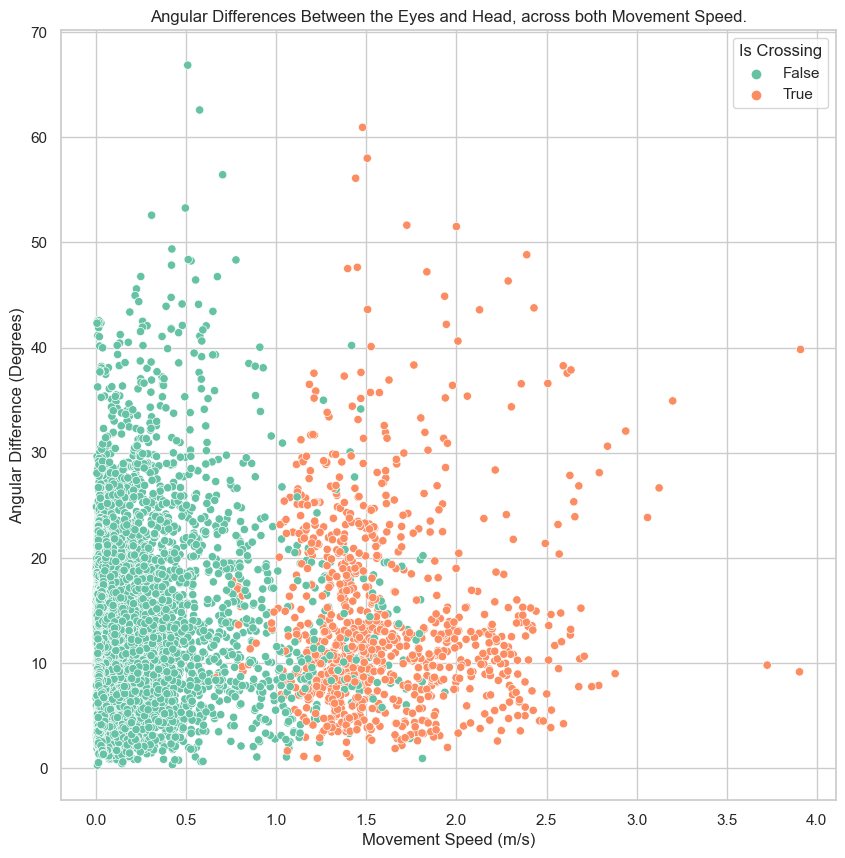

In [21]:
plt.figure(figsize=(10,10))

sns.scatterplot(
    data=eye2_df, x='movement_speed', y='angular_diff', 
    hue='crossing', palette='Set2'
)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Is Crossing')

plt.title('Angular Differences Between the Eyes and Head, across both Movement Speed.')
plt.xlabel('Movement Speed (m/s)')
plt.ylabel('Angular Difference (Degrees)')
plt.show()

I was hoping for something interesting here, but it looks like they are just two gigantic blobs. Don't get me wrong - their distributions are pretty consistent, as implied by the histograms we saw just above. But I was kind of hoping we would see some trend - i.e. as the person starts to move, we see some kind of trend that would implicate a regression. However, this feels pretty scattered already. Kind of useless, but still interesting to think about.

# Adding EEG Analysis

This one is the one I'm VERY interested in. Namely, I'm interested to see if there's any way we can use EEG to, for example, indicate when a person is fixating on something or is just passing a glance.

Processing EEG is a bit more difficult, namely due to the fact that 1) the EEG data is likely not going to be sampled at the same rate as our VR data, and 2) EEG analysis on a whole is rather complicated in of itself, what with the noisy nature of the EEG data.

In [participant_filtering.ipynb](participant_filtering.ipynb), we realized that **P1**, **P3**, and **P5** are valid for EEG analysis. P2, P4, and P6 featured too many gaps in the data to be actually useful. However, we'll proceed as best we can.

We will be replicating a TON of the stuff from [main.ipynb](main.ipynb). The main things we need to do are to normalize the trial EEG data with the resting state EEG data and align the EEG data with the gaze data.

In [16]:
# Imports
from helpers import timestamp_to_unix_seconds as unix_seconds
from helpers import timestamp_to_unix_milliseconds as unix_milliseconds

# EEG-specific Constants
_FREQUENCIES = ['Delta','Theta','Alpha','Beta','Gamma']
_ELECTRODES = ['AF7','AF8']
_FREQUENCY_COLORS = ['purple','red', 'blue', 'green', 'orange']
_REST_EEG_TIME_BOUNDS = (10000, 40000)

# Generate freq-band combination column names
freq_band_colnames = []
for freq in _FREQUENCIES: 
    for electrode in _ELECTRODES:
        freq_band_colnames.append(f'{freq}_{electrode}')


## Helper Functions

We need a helper function that can let us interpret EEG data. This one can technically be used universally as long as you have an actual EEG file.

In [17]:
# Pre-processing EEG data via transforming from log power to just power.
def LoadEEG(src_filepath:str, drop_raw:bool=True, drop_accel:bool=True, drop_gyro:bool=True):
    # Read the CSV data
    df = pd.read_csv(src_filepath)
    
    # Remove rows with empty timestamp or battery values.
    df = df[~df['TimeStamp'].isna()]
    df = df[~df['Battery'].isna()]
    
    # Calculate unix milliseconds, given the localized timestamp.
    df['unix_ms'] = df['TimeStamp'].apply(lambda x: int(unix_milliseconds(x)))

    # Drop useless columns
    drop_list = ['TimeStamp', 'Elements', 'Battery', 'HeadBandOn','AUX_RIGHT','AUX_LEFT','HSI_TP9','HSI_AF7','HSI_AF8','HSI_TP10']
    if drop_raw: drop_list.extend(['RAW_AF7','RAW_AF8','RAW_TP9','RAW_TP10'])
    if drop_accel: drop_list.extend(['Accelerometer_X','Accelerometer_Y','Accelerometer_Z'])
    if drop_gyro: drop_list.extend(['Gyro_X','Gyro_Y','Gyro_Z'])
    df.drop(columns=drop_list, inplace=True) # Drop useless columns
    
    # For each frequency, exit from log to actual power, then remove the older column
    for freq in _FREQUENCIES:
        for electrode in _ELECTRODES:
            in_colname = f'{freq}_{electrode}'
            out_colname = f'{in_colname}_Pow'
            df[out_colname] = 10 ** df[in_colname]
            df.drop(columns=[in_colname], inplace=True)
            df.rename(columns={out_colname:in_colname},inplace=True)
    
    # Return the EEG data
    return df

## Reading EEG Data

In [18]:
# Unlike eyes and gazes, we WON'T contatenate the users' data into  a singular DataFrame
# This is just to store the eeg for each participant.
eeg_dfs = []

# Iterate through all participants
for i in range(len(_PARTICIPANTS)):
    p = _PARTICIPANTS[i]
    pdir = os.path.join(_SAMPLES_DIR, p)
    files = get_immediate_files(pdir)
    if not 'eeg_rest.csv' in files:
        print(f"`eeg_rest.csv` is not present in {p}'s files")
        continue
    elif not 'eeg_vr.csv' in files:
        print(f"`eeg_vr.csv` is not present in {p}'s files'")
        continue
    
    # Read the trial data for this participant.
    # We simply need this to restrict the eye gazes between a time range.
    # We also do not include trial 0, which is the training phase for the user.
    trial_df = pd.read_csv(os.path.join(pdir,'trials.csv'))
    trial_df = trial_df.iloc[1:]
    start_unix = trial_df['start_unix'].iloc[0]
    end_unix = trial_df['end_unix'].iloc[-1]
    
    # We need to read the resting state EEG data.
    # We also isolate the resting state data to the bounds defined by `_REST_EEG_TIME_BOUNDS`.
    # This means we only use the rest data from between 10 to 40 seconds of the resting state time period.
    rest_eeg = LoadEEG(os.path.join(pdir, 'eeg_rest.csv')) 
    rest_eeg['rel_unix_ms'] = rest_eeg['unix_ms'] - rest_eeg['unix_ms'].iloc[0]
    rest_eeg = rest_eeg[
        (rest_eeg['rel_unix_ms']>= _REST_EEG_TIME_BOUNDS[0]) 
        & (rest_eeg['rel_unix_ms']<= _REST_EEG_TIME_BOUNDS[1])
    ]
    
    # Let's load in the actual trial EEG, 
    # restrict the EEG to trial timing, and 
    # normalize the data based on the rest state EEG.
    eeg_df = LoadEEG(os.path.join(pdir, 'eeg_vr.csv'))
    eeg_df = eeg_df[eeg_df['unix_ms'].between(start_unix, end_unix)]
    for freq_band in freq_band_colnames:
        # read the min and max of the provided frequency band
        freq_band_min = rest_eeg[freq_band].min()
        freq_band_max = rest_eeg[freq_band].max()
        eeg_df[freq_band] = (eeg_df[freq_band] - freq_band_min) / (freq_band_max - freq_band_min)
    
    # Store the EEG into `eeg_dfs`
    eeg_dfs.append(eeg_df)

## Raw EEG vs Gaze

The problem now is that we have raw eye data, gaze data, and eeg data. There are MANY ways to analyze these. Here are some distinct factoids to consider:

* Gazes, on average, last around 1-2 seconds. Some gaze points are longer or shorter than that, but these can be outliers. We may want to filter the eye gazes so that we remove any gazes that are outside 2 standard deviations of the mean?
* EEG can be sampled at either a HIGHER or a LOWER sample rate. This is because some participants' EEG was sampled at 0.5 second intervals, while others were at a constant interval.

One thing we can try to do is just put everything into a singular gantt chart-esque graph for each participant. That'll visually allow us to analyze each participants' EEG and compare it against gaze data. This would be similar to the visualizations done with SIGSIM PADS '25. In these visualizations:

* We have two subplots sharing an x-axis. The x-axis represents time (unix milliseconds) for both subplots. 
* The first subplot has a y-axis of distance, because we were initially curious about trends in EEG and gaze with relation to distance to the user.
* The second subplot is actually a combo of multiple subplots, one for each EEG frequency range.

C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: F

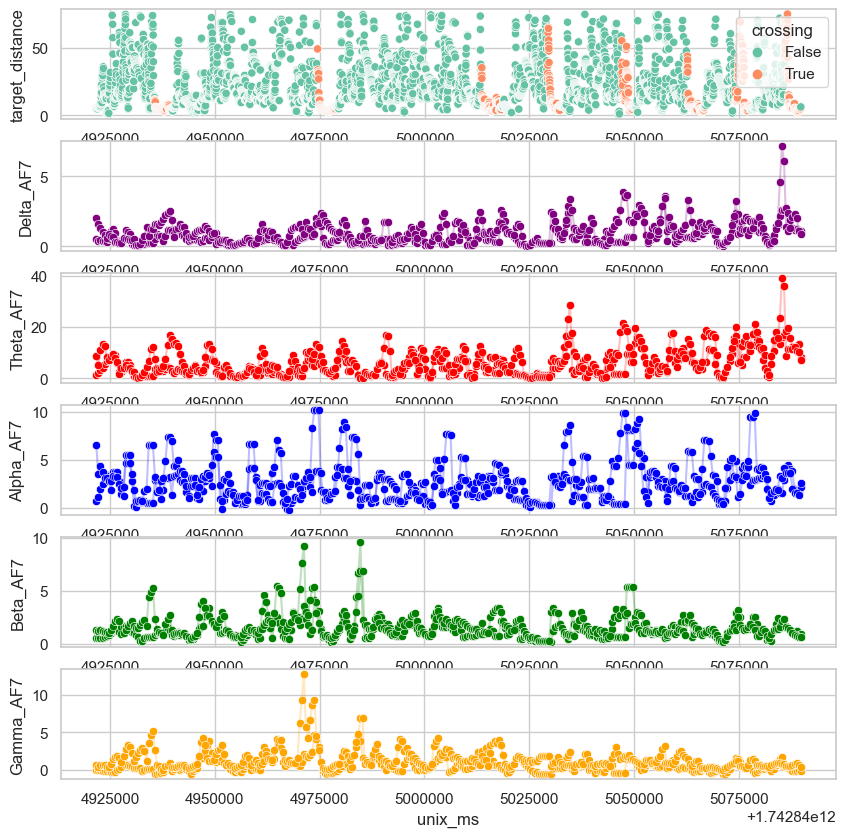

C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: F

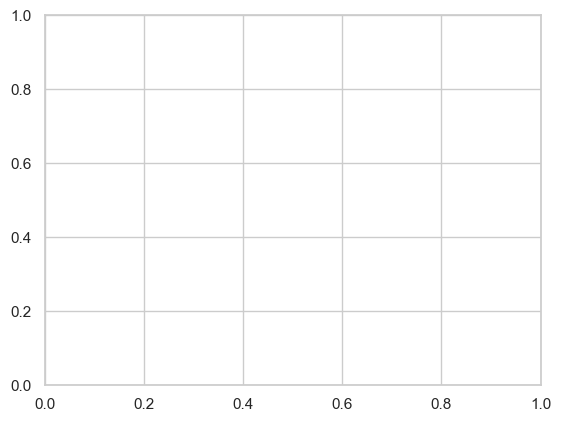

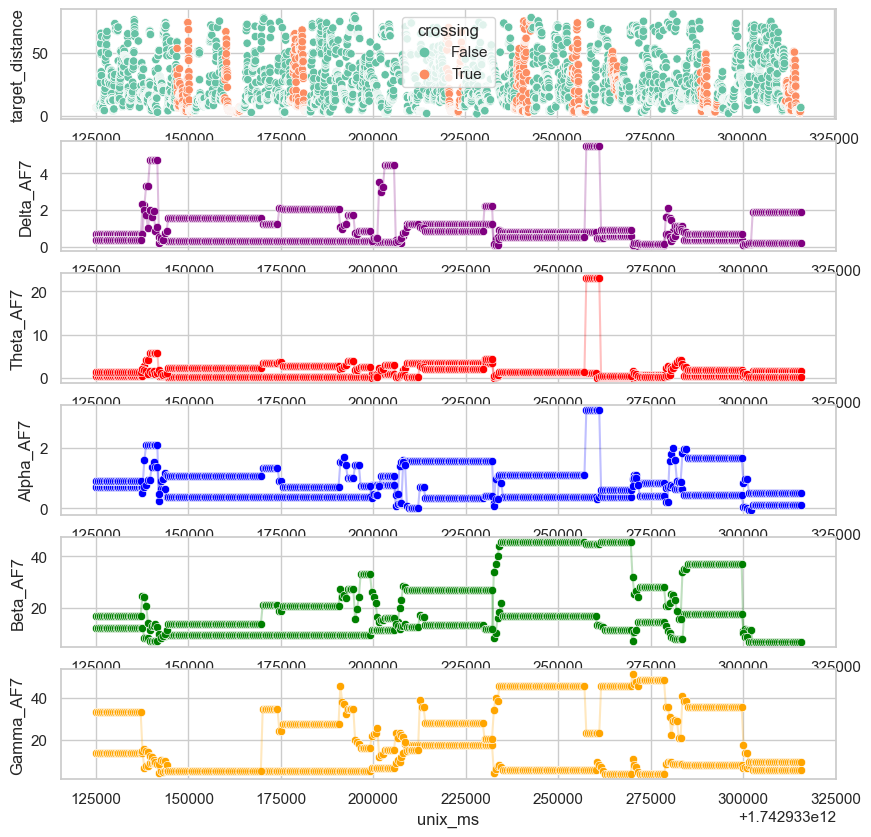

C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ryan Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: F

KeyboardInterrupt: 

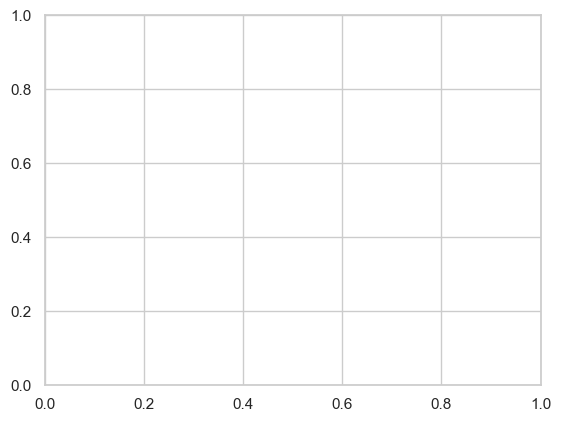

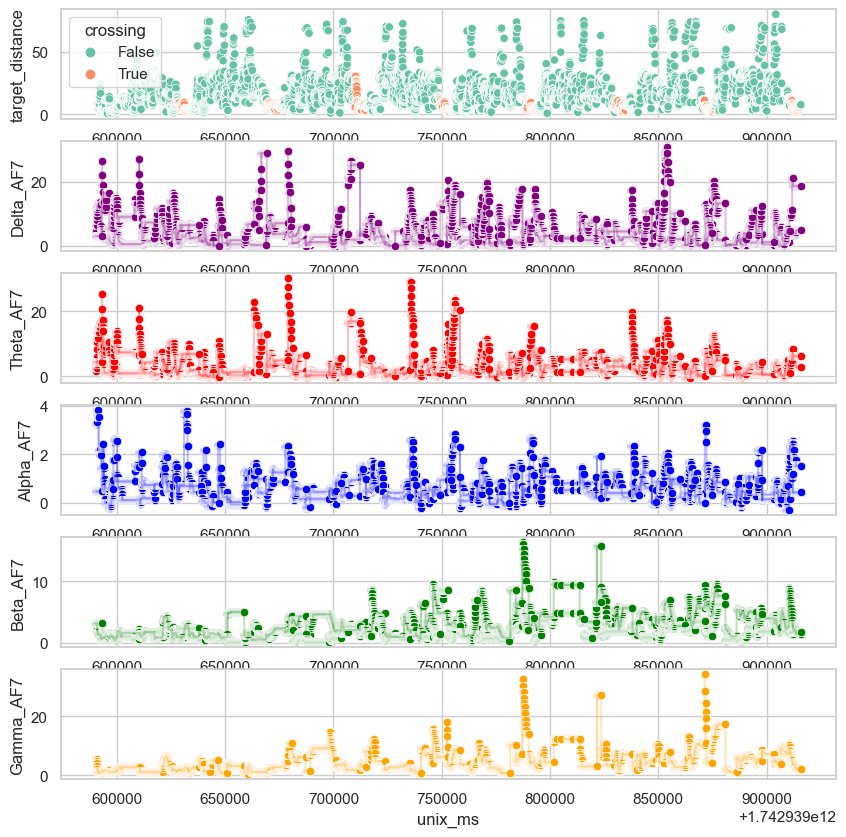

In [30]:
# We need to loop through the list of participants
for i in range(len(_PARTICIPANTS)):
    # let's load in the raw eye data and the eeg data for this participnat
    eye_df = eye_dfs[i]
    eeg_df = eeg_dfs[i]
    
    # Initialize the figure
    fig, axes = plt.subplots(nrows=1+len(_FREQUENCIES), ncols=1, figsize=(10,10))
    
    # Scatterplot for the eye data
    sns.scatterplot(
        data=eye_df[eye_df['target_distance'] < 100.0], 
        x='unix_ms', y='target_distance', hue='crossing', palette='Set2', ax=axes[0])
    
    # scatterplot for each eeg frequency
    for j in range(len(_ELECTRODES)):
        electrode = _ELECTRODES[j]
        for i in range(len(_FREQUENCIES)):
            color = _FREQUENCY_COLORS[i]
            freq = _FREQUENCIES[i]
            colname = f"{freq}_{electrode}"
            ax1 = sns.scatterplot(data=eeg_df, x='unix_ms', y=colname, ax=axes[i+1], color=color)
            ax1.legend_ = None
            ax2 = sns.lineplot(data=eeg_df, x='unix_ms', y=colname, ax=axes[i+1], color=color, alpha=0.25)
            ax2.legend_ = None    
    
    plt.show()
    plt.cla()
    
#for pdir in _PARTICIPANTS:
#    # Create output folder, if not exists
#    _ADD_OUTPUT_DIR2 = os.path.join(_ADD_OUTPUT_DIR, f'{pdir}/')
#    if not os.path.exists(_ADD_OUTPUT_DIR2): os.makedirs(_ADD_OUTPUT_DIR2)    
#    evc = global_evc_df[global_evc_df['participant']==pdir]
#    dfs = ProcessParticipant(os.path.join(_DATA_DIR, pdir), calculate_results=False)
#    durations = GetTrialDurations(dfs, [1,2,3,4,5,6])
#    eeg = dfs['eeg']
    
#    for i in range(6):
#        # should contain both eeg and gaze data for this trial
#        trial_evc = evc[evc['trial_number']==i+1]
        
#        trial_duration = durations.iloc[i].to_dict()
#        start_frame = trial_duration['trial_start_frame']
#        end_frame = trial_duration['crossing_end_frame']
#        frame_duration = end_frame - start_frame
        
#        fig, ax = plt.subplots(nrows=1, ncols=1)
#        fig.set_figheight(8)
#        fig.set_figwidth(12)
#        fig.suptitle(f'{pdir}) - Trial {i+1}: Gaze Hits on Vehicles', fontsize='xx-large', fontweight='bold')
#        plt.setp(plt.gcf().get_axes(), xlabel=None, ylabel=None);
#        ax.set_ylim([30, 52.5])
#        ax.xaxis.set_inverted(True)
        
#        # Coloration
#        points_color = [179, 162, 224]
#        clr = [x/255 for x in points_color]

        # Scatter
#        g0 = sns.scatterplot(
#            x='crossing_offset_unix_sec', 
#            y='screen_pos_z', 
#            data=trial_evc, 
#            color='blue',
#            sizes=(50, 200),
#            ax=ax
#        )
#        g0.set(xlabel=None, ylabel=None)
#        axxlim = ax.get_xlim()
#        ax.axvspan(axxlim[0], 0, color='red', alpha=0.05, zorder=0)
#        if (axxlim[1] < 0): ax.axvspan(axxlim[1], 0, color='blue', alpha=0.05, zorder=0)
#        min_vline_x = math.floor(axxlim[0]/5)+1
#        max_vline_x = math.ceil(-axxlim[1]/5)-1
#        print(min_vline_x, max_vline_x)
#        for j1 in range(0, min_vline_x):
#            ax.axvline(x=j1*5, c="gray", alpha=0.5)
#        ax.axvline(x=0, c="black")
#        plt.tight_layout()
#        plt.xticks(fontsize=15)
#        plt.yticks(fontsize=15)
#        plt.subplots_adjust(wspace=0, hspace=0)
#        plt.savefig(os.path.join(_ADD_OUTPUT_DIR2,f'{pdir}_trial-{i+1}_gaze_frequencies.png'), bbox_inches="tight", pad_inches=0.1)
#        plt.show()
#        plt.cla()

In [ ]:
fig, axes = plt.subplots(nrows=5,ncols=1, sharex=True)
fig.set_figheight(5)
fig.set_figwidth(15)

for j in range(len(_ELECTRODES)):
    electrode = _ELECTRODES[j]
    for i in range(len(_FREQUENCIES)):
        color = _FREQUENCY_COLORS[i]
        freq = _FREQUENCIES[i]
        colname = f"{freq}_{electrode}"
        ax1 = df.plot.scatter(x='unix_ms',y=colname, ax=axes[i], color=color)
        ax1.legend_ = None
        ax2 = df.plot.line(x='unix_ms', y=colname, ax=axes[i], color=color, alpha=0.25)
        ax2.legend_ = None

In [ ]:
def PlotEEGHorizontal2(df, frequencies, electrodes, colors, trial_df=None, suptitle:str=None, save_figname:str=None):
    # Let's display this participant's EEG data
    fig, axes = plt.subplots(nrows=4,ncols=1, sharex=True)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    
    for j in range(len(electrodes)):
        electrode = electrodes[j]
        for i in range(len(frequencies)):
            color = colors[i]
            freq = frequencies[i]
            colname = f"{freq}_{electrode}_normalized"
            ax = df.plot.scatter(x='unix_ms',y=colname, ax=axes[i], color=color)
            ax.legend_ = None
        for i in range(len(frequencies)):
            color = colors[i]
            freq = frequencies[i]
            colname = f"{freq}_{electrode}_normalized"
            ax = df.plot.line(x='unix_ms',y=colname, ax=axes[i], color=color, alpha=0.25)
            ax.legend_ = None    
    
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None, ylabel=None);
    plt.subplots_adjust(wspace=0, hspace=0)
    if save_figname: 
        plt.savefig(f'{save_figname}_{electrode}', bbox_inches="tight", pad_inches=0)
    plt.cla()
        
for pdir in _PARTICIPANTS:
    # Create output folder, if not exists
    _ADD_OUTPUT_DIR2 = os.path.join(_ADD_OUTPUT_DIR, f'{pdir}/')
    if not os.path.exists(_ADD_OUTPUT_DIR2): os.makedirs(_ADD_OUTPUT_DIR2)
    
    dfs = ProcessParticipant(os.path.join(_DATA_DIR, pdir), calculate_results=False)
    eeg = dfs['eeg']
    trial_timings = dfs['trial']
    
    for i in [1,2,3,4,5,6]:
        # should contain both eeg and gaze data for this trial
        trial_duration = trial_timings[trial_timings['trial_number']==i].iloc[0].to_dict()
        print(trial_duration)
        trial_eeg = eeg[(eeg['unix_ms'] >= trial_duration['start_unix']) & (eeg['unix_ms'] < trial_duration['end_unix'])]
        display(trial_eeg)
        save_filename = os.path.join(_ADD_OUTPUT_DIR2, f'{pdir}_trial-{i}_eeg')
        print(save_filename)
        PlotEEGHorizontal2(
            trial_eeg, 
            _FREQUENCY_BANDS, 
            _ELECTRODES, 
            _FREQUENCY_COLORS, 
            save_figname=save_filename
        )

We have a function called `GetGazeWindowEEGs(row, eeg, colnames)` from [main.ipynb](main.ipynb) that was intended to combine gaze and EEG. In this function, the `row` references a row from the gazes DataFrame. The `eeg` is the entire normalized EEG dataframe. `colnames` is an array of frequency-band combinations, which correpond to columns in the EEG dataframe.

The original intention here was to, for each unique gaze target, measure the EEG frequency power along the following time axes:

* **Prior**: from 2 seconds prior to the onset of the gaze fixation.
* **During**: from 1 second prior to 1 second after the onset of the gaze fixation
* **After**: from the onset of gaze fixation to 2 second after the onset.

We use these distinct timings because it's possible for a gaze fixations to last a long time.

In [ ]:
# Helper Function: must return a dict with the new colnames
def GetGazeWindowEEGs(row, eeg, colnames):
    # Initialize return dict
    return_dict = {}
    # Get gaze target qualities
    return_dict['target_type'] = _OBJECT_TYPE_DICT[row['target_name']]
    return_dict['target_state'] = _OBJECT_STATE_DICT[row['target_name']]
    # For each freq_band column name, get the prior, during, and after windows
    prior = eeg[eeg['unix_ms'].between(row['start_unix_ms']-2000, row['start_unix_ms'])]
    during = eeg[eeg['unix_ms'].between(row['start_unix_ms']-1000, row['start_unix_ms']+1000)]
    after = eeg[eeg['unix_ms'].between(row['start_unix_ms'], row['start_unix_ms']+2000)]
    for col in colnames:
        return_dict[f'{col}-prior_avg'] = prior[f'{col}_normalized'].mean()
        return_dict[f'{col}-prior_max'] = prior[f'{col}_normalized'].max()
        return_dict[f'{col}-during_avg'] = during[f'{col}_normalized'].mean()
        return_dict[f'{col}-during_max'] = during[f'{col}_normalized'].max()
        return_dict[f'{col}-after_avg'] = after[f'{col}_normalized'].mean()
        return_dict[f'{col}-after_max'] = after[f'{col}_normalized'].max()
    return return_dict